Борисенко Дмитрий Антонович РИ-230945

# imports

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import json
import time

# Datasets

In [35]:
class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transform
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


class CIFARDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.CIFAR10(
            root='./data',
            train=train,
            download=True,
            transform=transform
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = MNISTDataset(train=True, transform=transform)
    test_dataset = MNISTDataset(train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


def get_cifar_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    train_dataset = CIFARDataset(train=True, transform=transform)
    test_dataset = CIFARDataset(train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Задание 1: Эксперименты с глубиной сети

1.1 Сравнение моделей разной глубины

Создайте и обучите модели с различным количеством слоев:

- 1 слой (линейный классификатор)
- 2 слоя (1 скрытый)
- 3 слоя (2 скрытых)
- 5 слоев (4 скрытых)
- 7 слоев (6 скрытых)

Для каждого варианта:
- Сравните точность на train и test
- Визуализируйте кривые обучения
- Проанализируйте время обучения

In [ ]:
# Данные
train_loader, test_loader = get_mnist_loaders(batch_size=64)

In [37]:
class FullyConnectedModel(nn.Module):
    def __init__(self, config_path=None, input_size=None, num_classes=None, **kwargs):
        super().__init__()

        if config_path:
            self.config = self.load_config(config_path)
        else:
            self.config = kwargs

        self.input_size = input_size or self.config.get('input_size', 784)
        self.num_classes = num_classes or self.config.get('num_classes', 10)

        self.layers = self._build_layers()

    def load_config(self, config_path):
        """Загружает конфигурацию из JSON файла"""
        with open(config_path, 'r') as f:
            return json.load(f)

    def _build_layers(self):
        layers = []
        prev_size = self.input_size

        layer_config = self.config.get('layers', [])

        for layer_spec in layer_config:
            layer_type = layer_spec['type']

            if layer_type == 'linear':
                out_size = layer_spec['size']
                layers.append(nn.Linear(prev_size, out_size))
                prev_size = out_size

            elif layer_type == 'relu':
                layers.append(nn.ReLU())

            elif layer_type == 'sigmoid':
                layers.append(nn.Sigmoid())

            elif layer_type == 'tanh':
                layers.append(nn.Tanh())

            elif layer_type == 'dropout':
                rate = layer_spec.get('rate', 0.5)
                layers.append(nn.Dropout(rate))

            elif layer_type == 'batch_norm':
                layers.append(nn.BatchNorm1d(prev_size))

            elif layer_type == 'layer_norm':
                layers.append(nn.LayerNorm(prev_size))

        layers.append(nn.Linear(prev_size, self.num_classes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)


def create_model_from_config(config_path, input_size=None, num_classes=None):
    """Создает модель из JSON конфигурации"""
    return FullyConnectedModel(config_path, input_size, num_classes)

In [38]:
configs = {
    "linear": {
        "input_size": 784,
        "num_classes": 10,
        "layers": []
    },
    "1hidden": {
        "input_size": 784,
        "num_classes": 10,
        "layers": [
            {"type": "linear", "size": 128},
            {"type": "relu"}
        ]
    },
    "2hidden": {
        "input_size": 784,
        "num_classes": 10,
        "layers": [
            {"type": "linear", "size": 256},
            {"type": "relu"},
            {"type": "linear", "size": 128},
            {"type": "relu"}
        ]
    },
    "4hidden": {
        "input_size": 784,
        "num_classes": 10,
        "layers": [
            {"type": "linear", "size": 512},
            {"type": "relu"},
            {"type": "linear", "size": 256},
            {"type": "relu"},
            {"type": "linear", "size": 128},
            {"type": "relu"},
            {"type": "linear", "size": 64},
            {"type": "relu"}
        ]
    },
    "6hidden": {
        "input_size": 784,
        "num_classes": 10,
        "layers": [
            {"type": "linear", "size": 512},
            {"type": "relu"},
            {"type": "linear", "size": 256},
            {"type": "relu"},
            {"type": "linear", "size": 128},
            {"type": "relu"},
            {"type": "linear", "size": 64},
            {"type": "relu"},
            {"type": "linear", "size": 32},
            {"type": "relu"}
        ]
    }
}

for name, config in configs.items():
    with open(f"{name}.json", "w") as f:
        json.dump(config, f, indent=2)

In [39]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_acc_history = []
    test_acc_history = []
    times = []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        start_time = time.time()

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        train_acc_history.append(train_acc)
        times.append(time.time() - start_time)

        # Тест
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        test_acc = correct / total
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Time: {times[-1]:.2f}s")

    return train_acc_history, test_acc_history, times


In [40]:
def plot_curves(train_acc, test_acc, label):
    plt.plot(train_acc, label=f'{label} - Train')
    plt.plot(test_acc, label=f'{label} - Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train/Test Accuracy')
    plt.legend()
    plt.grid(True)

cuda
Epoch 1/10, Train Acc: 0.8903, Test Acc: 0.9198, Time: 12.86s
Epoch 2/10, Train Acc: 0.9169, Test Acc: 0.9196, Time: 14.30s
Epoch 3/10, Train Acc: 0.9200, Test Acc: 0.9207, Time: 13.84s
Epoch 4/10, Train Acc: 0.9230, Test Acc: 0.9237, Time: 13.46s
Epoch 5/10, Train Acc: 0.9247, Test Acc: 0.9237, Time: 12.77s
Epoch 6/10, Train Acc: 0.9247, Test Acc: 0.9213, Time: 13.11s
Epoch 7/10, Train Acc: 0.9256, Test Acc: 0.9232, Time: 13.63s
Epoch 8/10, Train Acc: 0.9262, Test Acc: 0.9243, Time: 12.76s
Epoch 9/10, Train Acc: 0.9275, Test Acc: 0.9230, Time: 12.74s
Epoch 10/10, Train Acc: 0.9279, Test Acc: 0.9251, Time: 12.95s
Epoch 1/10, Train Acc: 0.9241, Test Acc: 0.9562, Time: 12.93s
Epoch 2/10, Train Acc: 0.9666, Test Acc: 0.9665, Time: 13.32s
Epoch 3/10, Train Acc: 0.9756, Test Acc: 0.9726, Time: 13.36s
Epoch 4/10, Train Acc: 0.9816, Test Acc: 0.9745, Time: 13.20s
Epoch 5/10, Train Acc: 0.9852, Test Acc: 0.9713, Time: 13.17s
Epoch 6/10, Train Acc: 0.9875, Test Acc: 0.9734, Time: 14.44s
Ep

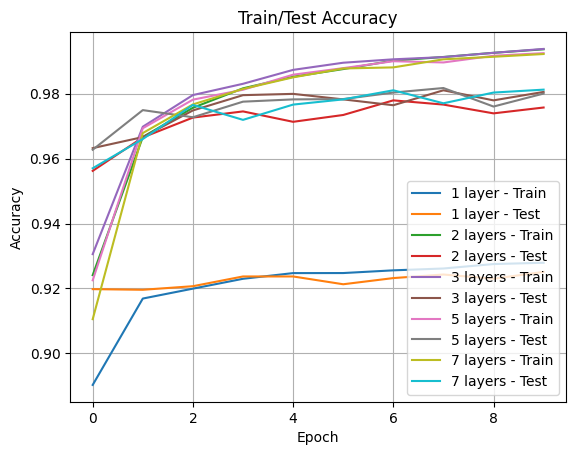

In [42]:
configs = {
    "1 layer": "linear.json",
    "2 layers": "1hidden.json",
    "3 layers": "2hidden.json",
    "5 layers": "4hidden.json",
    "7 layers": "6hidden.json"
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
for name, config in configs.items():
    model = create_model_from_config(config, input_size=784, num_classes=10)
    train_acc, test_acc, times = train_model(model, train_loader, test_loader, epochs=10, device=device)
    plot_curves(train_acc, test_acc, label=name)

# Задание 2: Эксперименты с шириной сети (25 баллов)

2.1 Сравнение моделей разной ширины (15 баллов)

Создайте модели с различной шириной слоев:
- Узкие слои: [64, 32, 16]
- Средние слои: [256, 128, 64]
- Широкие слои: [1024, 512, 256]
- Очень широкие слои: [2048, 1024, 512]

Для каждого варианта:
- Поддерживайте одинаковую глубину (3 слоя)
- Сравните точность и время обучения
- Проанализируйте количество параметров

In [43]:
width_configs = {
    "narrow": {
        "input_size": 784,
        "num_classes": 10,
        "layers": [
            {"type": "linear", "size": 64},
            {"type": "relu"},
            {"type": "linear", "size": 32},
            {"type": "relu"},
            {"type": "linear", "size": 16},
            {"type": "relu"}
        ]
    },
    "medium": {
        "input_size": 784,
        "num_classes": 10,
        "layers": [
            {"type": "linear", "size": 256},
            {"type": "relu"},
            {"type": "linear", "size": 128},
            {"type": "relu"},
            {"type": "linear", "size": 64},
            {"type": "relu"}
        ]
    },
    "wide": {
        "input_size": 784,
        "num_classes": 10,
        "layers": [
            {"type": "linear", "size": 1024},
            {"type": "relu"},
            {"type": "linear", "size": 512},
            {"type": "relu"},
            {"type": "linear", "size": 256},
            {"type": "relu"}
        ]
    },
    "very_wide": {
        "input_size": 784,
        "num_classes": 10,
        "layers": [
            {"type": "linear", "size": 2048},
            {"type": "relu"},
            {"type": "linear", "size": 1024},
            {"type": "relu"},
            {"type": "linear", "size": 512},
            {"type": "relu"}
        ]
    }
}

for name, config in configs.items():
    with open(f"{name}.json", "w") as f:
        json.dump(config, f, indent=2)

In [44]:
def count_parameters(model):
    """Подсчитывает количество параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Training narrow model...
Epoch 1/5, Train Acc: 0.8892, Test Acc: 0.9200, Time: 13.16s
Epoch 2/5, Train Acc: 0.9166, Test Acc: 0.9169, Time: 13.17s
Epoch 3/5, Train Acc: 0.9205, Test Acc: 0.9232, Time: 12.84s
Epoch 4/5, Train Acc: 0.9220, Test Acc: 0.9218, Time: 12.82s
Epoch 5/5, Train Acc: 0.9233, Test Acc: 0.9237, Time: 12.70s
Training medium model...
Epoch 1/5, Train Acc: 0.8890, Test Acc: 0.9143, Time: 12.80s
Epoch 2/5, Train Acc: 0.9172, Test Acc: 0.9182, Time: 12.96s
Epoch 3/5, Train Acc: 0.9209, Test Acc: 0.9205, Time: 12.79s
Epoch 4/5, Train Acc: 0.9226, Test Acc: 0.9199, Time: 12.70s
Epoch 5/5, Train Acc: 0.9242, Test Acc: 0.9224, Time: 12.63s
Training wide model...
Epoch 1/5, Train Acc: 0.8870, Test Acc: 0.9178, Time: 12.73s
Epoch 2/5, Train Acc: 0.9157, Test Acc: 0.9195, Time: 12.99s
Epoch 3/5, Train Acc: 0.9210, Test Acc: 0.9220, Time: 12.86s
Epoch 4/5, Train Acc: 0.9235, Test Acc: 0.9242, Time: 12.85s
Epoch 5/5, Train Acc: 0.9241, Test Acc: 0.9246, Time: 13.40s
Training ver

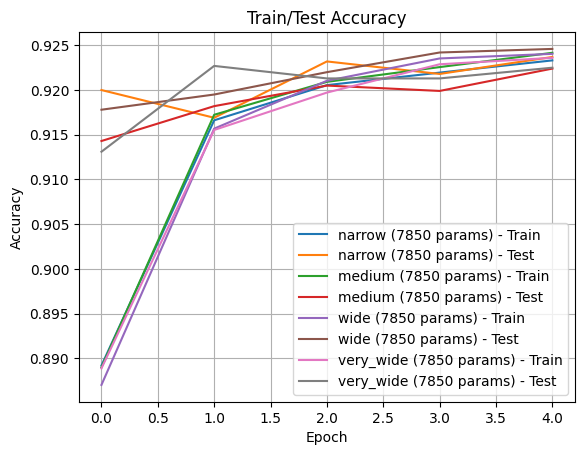

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, test_loader = get_mnist_loaders(batch_size=64)

results = {}

for width_name, config in width_configs.items():
    print(f"Training {width_name} model")
    model = FullyConnectedModel(config=config).to(device)

    train_acc, test_acc, times = train_model(model, train_loader, test_loader, epochs=5, device=device)

    params = count_parameters(model)

    results[width_name] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'times': times,
        'params': params
    }

    plot_curves(train_acc, test_acc, label=f'{width_name} ({params} params)')